# Dual SDDP 

Warning: This notebook does not provide the same results as in the article 

Leclère, Vincent, et al. "Exact converging bounds for Stochastic Dual Dynamic Programming via Fenchel duality." (2018).

The only raison is that we do not fix the same seeds. 

In [1]:
# we use Matplotlib for plots
using PyPlot

In [2]:
# import source code
include("src/dualSDDP.jl");

# Toy example

We first test dual SDDP on a trivial example, with a single node and 3 stages. 
Normally, we should obtain a gap close to 0. 

In [3]:
# number of stages in SP problem
nstages = 3
# number of bins to quantize random noises. The bigger, the heavier is the stochasticity
nbins = 10
# build corresponding problem, with a single node corresponding to France
srand(11)
mpts = MPTS([:FRA], nstages, nbins);

In [4]:
# build primal and dual SDDP
psddp = initprimal(mpts);
dsddp = initdual(mpts, psddp);

SDDP Interface initialized
SDDP Interface initialized


In [5]:
# run jointly primal and dual SDDP
lbdual, timedual = runjoint!(psddp, dsddp, maxiterations=20);

RUN DUAL SDDP
Pass n° 10	LB: 5.9070e+04 	UB: 5.9070e+04 
Pass n° 20	LB: 5.9070e+04 	UB: 5.9070e+04 
Total exec time: 0.752646093


In [6]:
# primal lower bound
lb_p = psddp.stats.lowerbound
# dual upper bound
ub_d = lbdual[end]

println("Final gap: ", round(100*(ub_d / lb_p - 1), 4), " %")

Final gap: 0.0 %


Gap is equal to 0! 

# Overall example

We now build the complete example, corresponding to the overall European network. 
We refer to the orginal article for a complete description of the problem. 

In [7]:
nstages = 12
nbins = 10
names = [:FRA, :GER, :ESP, :UK, :PT, :ITA, :SUI] 
# WARNING: you could also add Belgium to the European network:
## names = [:FRA, :GER, :ESP, :UK, :PT, :ITA, :SUI, :BEL] 
# but as Belgium does not have any dam, this would lead to small instabilities (co-state of a value functions reduced
# to a single point)

7-element Array{Symbol,1}:
 :FRA
 :GER
 :ESP
 :UK 
 :PT 
 :ITA
 :SUI

We initiate the MPTS problem.

In [8]:
# WARNING: the sampling of the noise depends on the kmeans algorithm
# which initiates its initial clusters centers randomly. Thus,
# the noise sampling is random. For reproductability, we fix 
# the seed to ensure that we always build the same problem
srand(2713);
mpts = MPTS(names, nstages, nbins);

In [9]:
psddp = initprimal(mpts);
dsddp = initdual(mpts, psddp);

SDDP Interface initialized
SDDP Interface initialized


Launch SDDP dual.

In [10]:
lbdual, timedual = runjoint!(psddp, dsddp, maxiterations=250);

RUN DUAL SDDP
Pass n° 10	LB: 5.7753e+05 	UB: 4.5578e+07 
Pass n° 20	LB: 5.8673e+05 	UB: 4.5931e+06 
Pass n° 30	LB: 5.9094e+05 	UB: 2.4034e+06 
Pass n° 40	LB: 6.0693e+05 	UB: 1.3220e+06 
Pass n° 50	LB: 6.1358e+05 	UB: 1.1057e+06 
Pass n° 60	LB: 6.2104e+05 	UB: 9.5369e+05 
Pass n° 70	LB: 6.2834e+05 	UB: 9.0456e+05 
Pass n° 80	LB: 7.5968e+05 	UB: 8.7248e+05 
Pass n° 90	LB: 7.6986e+05 	UB: 8.5147e+05 
Pass n° 100	LB: 7.8754e+05 	UB: 8.4663e+05 
Pass n° 110	LB: 8.0035e+05 	UB: 8.3554e+05 
Pass n° 120	LB: 8.0238e+05 	UB: 8.3303e+05 
Pass n° 130	LB: 8.0258e+05 	UB: 8.3144e+05 
Pass n° 140	LB: 8.0835e+05 	UB: 8.3018e+05 
Pass n° 150	LB: 8.0918e+05 	UB: 8.2815e+05 
Pass n° 160	LB: 8.1898e+05 	UB: 8.2674e+05 
Pass n° 170	LB: 8.2071e+05 	UB: 8.2572e+05 
Pass n° 180	LB: 8.2132e+05 	UB: 8.2508e+05 
Pass n° 190	LB: 8.2179e+05 	UB: 8.2475e+05 
Pass n° 200	LB: 8.2206e+05 	UB: 8.2433e+05 
Pass n° 210	LB: 8.2234e+05 	UB: 8.2400e+05 
Pass n° 220	LB: 8.2239e+05 	UB: 8.2379e+05 
Pass n° 230	LB: 8.2246e+05 

In [11]:
lb_p = psddp.stats.lowerbound
ub_d = lbdual[end]

println("Final gap: ", round(100*(ub_d / lb_p - 1), 4), " %")

Final gap: 0.119 %


In [12]:
lbprim = psddp.stats.lower_bounds;

We plot evolution of primal LB and dual UB. 

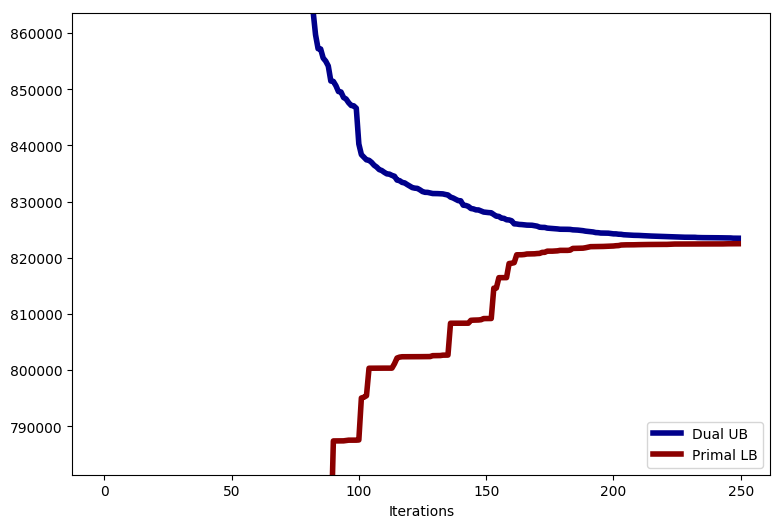

(781379.9029689472, 863630.4190709417)

In [13]:
figure(figsize=(9,6))

plot(lbdual, c="darkblue", lw=4, label="Dual UB")
plot(lbprim, c="darkred", lw=4, label="Primal LB")
legend(loc=4)
xlabel("Iterations")
ylim(.95lb_p, 1.05lb_p)


# IA strategy

We now test Inner Strategy (IA), and compare it with the outer approximation (OA).

In [14]:
# we copy the cuts previously computed
V_primal = copy(psddp.bellmanfunctions);
V_dual = copy(dsddp.bellmanfunctions);

### Compute outer strategy

In [15]:
# get costs of OA over 1000 scenarios
c_oa = SDDP.simulate(psddp, 1000)[1];

In [16]:
ub_oa = mean(c_oa)

822446.9961925863

### Compute inner strategy

In [17]:
# we init the JuMP model inside the primal SDDP object (we simulate in the primal, not in the dual!)
init_innermodeler!(psddp, V_dual)

In [18]:
# get costs of IA over 1000 scenarios
c_ia = SDDP.simulate(psddp, 1000)[1];

In [19]:
ub_ia = mean(c_ia)

822618.0823081832

IA costs must be lower than dual upper bound!

In [20]:
ub_ia <= ub_d

true

### Comparison of IA with OA

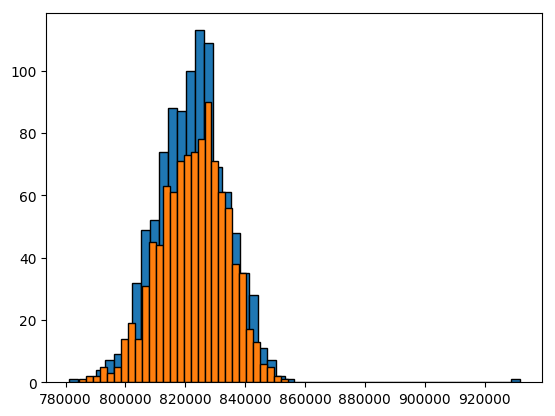

In [21]:
PyPlot.plt[:hist](c_oa, 50, edgecolor="k")
PyPlot.plt[:hist](c_ia, 30, edgecolor="k");

We observe that OA average costs is close to IA average costs.